<h1 align="center"><font color='#355C7D'>Automatically Masking Cartridge Case Images</font></h1>

<h4 align="center">Tommy Flynn | tommyflynn@rogers.com | 519-209-1361 |  <a href=https://www.linkedin.com/in/tfln>LinkedIn</a></h4>

### <font color='#F67280'>Table of contents<font><a class='anchor' id='top'></a>
1. [Introduction](#intro) <br>
2. [Set Up](#setup) <br>
3. [Algorithm](#alg) <br>
4. [Conclusion](#conclusion)


<a id='intro'><h2 align="left"><font color='#355C7D'>1. Introduction</font></h2></a>

When ammunition is fired, the components of the weapon leave distinctive marks on the cartridge cases. The identification and differentiation of these marks hold significance in forensic science, particularly in ascertaining the weapon of origin for the cartridge. Currently, the process of masking or coloring these regions is carried out manually, entailing a time consuming effort. The objective of this project is to develop an algorithm capable of automatically masking fired cartridge case images, thereby streamlining the process and conserving resources.

<a id='setup'><h2 align="left"><font color='#355C7D'>2. Set Up</font></h2></a>

- First, we import the required libraries: 
    - __OpenCV__ for image processing.
    - __NumPy__ for numerical computation.
    - __Matplotlib__ for data visualization.

In [67]:
# Load libraries
import cv2                          
import numpy as np                  
import matplotlib.pyplot as plt     
np.random.seed(13)                 

# Function for quick quick visualization of images.
def see(images, titles=None, figsize=(8, 4), dpi=100):
    num_images = len(images)
    if num_images == 1:
        plt.figure(figsize=figsize, dpi=dpi)
        plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        plt.title(titles[0])
        plt.show()
    else:
        fig, axes = plt.subplots(1, num_images, figsize=figsize, dpi=dpi)
        for i in range(num_images):
            axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            axes[i].axis('off')  # Turn off axis labels
            axes[i].set_title(titles[i])
        plt.tight_layout()
        plt.show()

- Next, we load and visualize the original and manually masked cartridge case images.
- The mask consists of 5 colored regions:
    1.	The breech-face impression (red)
    2.	The aperture shear (green)
    3.	The firing pin impression (purple)
    4.	The firing pin drag (light blue) 
    5.	The direction of the firing pin drag (blue arrow)


Image Dimensions: (716, 730, 3)


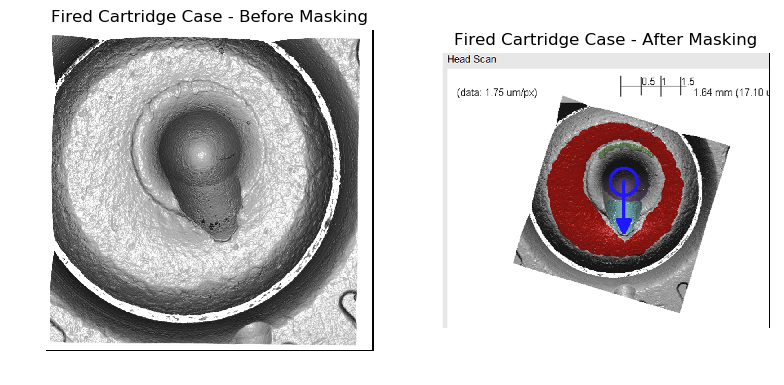

In [68]:
original = cv2.imread('before_masking.png')     # Load before masking image 
manual = cv2.imread('after_masking.png')        # Load after masking image  
n, p, c = np.shape(original)                    # Dimensions 

print(f'Image Dimensions: {(n,p,c)}')
see([original, manual], ['Fired Cartridge Case - Before Masking', 'Fired Cartridge Case - After Masking'])                                                                                           

<a id='alg'><h2 align="left"><font color='#355C7D'>3. Algorithm</font></h2></a>

- Notice that the outer boundaries enclosing the breech face and firing pin impressions are roughly circular.
- Let's process the image to accentuate these regions and then apply a circle detector.  

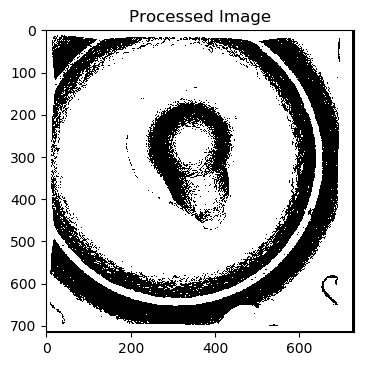

In [69]:
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)               # Convert to grayscale 
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)    # Highlight regions of interest
equ = cv2.equalizeHist(thresh)                                  # Enhance contrast

see([equ], ['Processed Image'])

- To search for circles in the processed image we use the Circle Hough Transform, which specialized in circular feature extraction.  

In [70]:
def detect_circle(image, min_rad, max_rad, color):
    # Searches for circles in the image within min_rad to max_rad. 
    # A mask is then created using the best circle.

     # Detect circles   
    circles = cv2.HoughCircles(
        image, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=20,  
        param1=50,  
        param2=15,  
        minRadius=min_rad,  
        maxRadius=max_rad)  
                                                   
    # Select best circle 
    circle = np.uint16(np.around(circles[0][0]))                            
    center = [circle[0], circle[1]]                                          
    radius = circle[2]                                                      

    # Create circular mask 
    circular_mask = np.zeros((n, p, 3), dtype=np.uint8)                      
    cv2.circle(circular_mask, center, radius, color, thickness=-1)         
    circular_mask_gray = cv2.cvtColor(circular_mask, cv2.COLOR_BGR2GRAY)    
    circular_mask_gray[np.where(circular_mask_gray != 0)] = 255
    return [circular_mask, circular_mask_gray, radius, center]

# Breech face mask 
bf_mask, bf_gray, bf_rad, bf_center = detect_circle(equ, int(max(n, p)/4), 0, (15, 21, 139))
# Firing pin mask 
fp_mask, fp_gray, fp_rad, fp_center = detect_circle(equ, 0, int(bf_rad/2), (67, 47, 60))

- The current region of interest lies within these circles. 
- Let's create an annular mask to extract this area. 

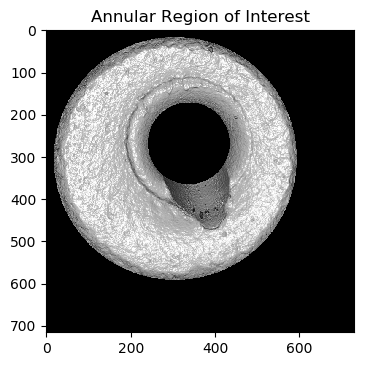

In [71]:
annular_mask = cv2.subtract(bf_gray, fp_gray)
roi = cv2.bitwise_and(gray, gray, mask=annular_mask)

see([roi], ['Annular Region of Interest'])

- There appears to be a small map pin icon formed by the firing pin impression and its drag mark.
- There is also a large map pin icon formed by a slightly larger circle and the drag mark.   
- To extract these regions, we process them and perform edge detection.

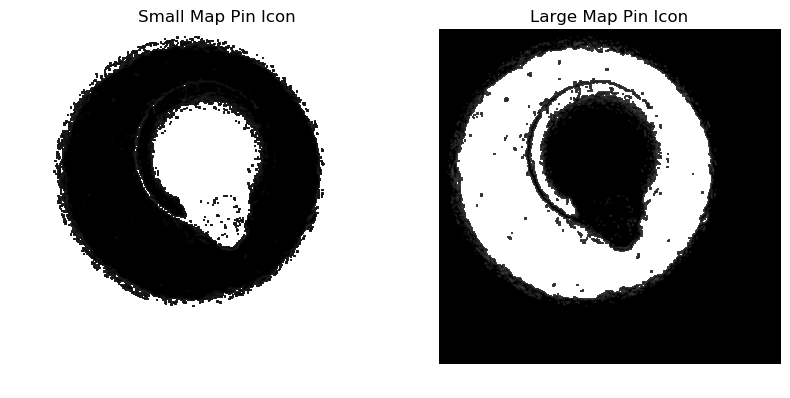

In [72]:
_, thresh = cv2.threshold(255 - roi, 100, 255, cv2.THRESH_BINARY) 
blurred_small = cv2.GaussianBlur(thresh, (5, 5), 0)
equ_small = cv2.equalizeHist(blurred_small)
k = 255 - thresh
blurred_large = cv2.GaussianBlur(k, (5, 5), 0)
equ_large = cv2.equalizeHist(blurred_large)

see([equ_small, equ_large], ['Small Map Pin Icon', 'Large Map Pin Icon'])

- To create masks of these regions, we use a combination of Canny edge detection and contour filling. 

In [73]:
def map_pin_mask(image, color):
    # Creates mask using edge detection and contour filling. 
    edges = cv2.Canny(image, 50, 150)                                                   
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    
    largest_contour =  max(contours, key=cv2.contourArea)                               
    pin_mask = np.zeros((n,p,3), dtype=np.uint8)                                        
    hull = cv2.convexHull(largest_contour)
    cv2.drawContours(pin_mask, [hull], 0,  color, thickness=cv2.FILLED)
    pin_mask_gray = cv2.cvtColor(pin_mask, cv2.COLOR_BGR2GRAY) 
    return(pin_mask, pin_mask_gray, hull)

# Large map pin mask 
mp_large, mp_large_gray, hull_large = map_pin_mask(equ_large, (0, 95, 0))
# Small map pin mask
mp_small, mp_small_gray, hull_small = map_pin_mask(equ_small, (130, 134, 77))

- Finally, we color the original image using the regions we have created above:

1. __Breech face impression:__  <br>
     - Obtained by subtracting the large map pin icon from its outer circle. <br><br>
2. __Aperture shear:__ <br>
     - Obtained by subtracting the small map pin icon from the large map pin icon.  <br><br>
3. __Direction of the firing pin drag:__ <br>
     - Defined as the line connecting the center of the firing pin circle to the point of greatest distance in the small map pin icon. <br><br>
4. __Firing pin impression:__ <br>
     - Obtained from its outer circle. <br><br>
5. __Firing pin drag:__ <br> 
     - Defined by all points on the small map pin icon that are:
        - Outside of the firing pin impression.
        - Within the length of the drag line away from the farthest point.  
        - Within the firing pin radius away from the drag line.

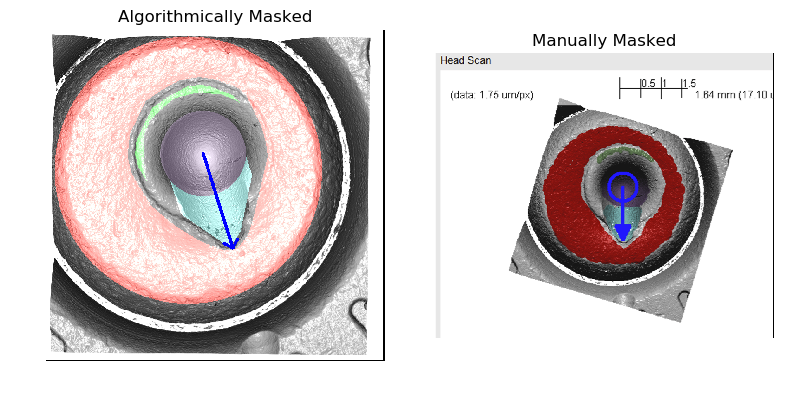

In [74]:
# Breech face impression 
breech_face = bf_mask
breech_face[np.where(mp_large_gray != 0)] = [0, 0, 0]

# Aperture shear
aperture_shear = mp_large 
aperture_shear[np.where(mp_small_gray != 0)] = [0, 0, 0]
aperture_shear = cv2.erode(aperture_shear, np.ones((5, 5), np.uint8), iterations=7)

# Direction of the firing pin drag
farthest_point = None
max_distance = 0
for pt in hull_small:
    distance = np.sqrt((fp_center[0] - pt[0][0])**2 + (fp_center[1] - pt[0][1])**2)
    if distance > max_distance:
        max_distance = distance
        farthest_point = (pt[0][0], pt[0][1])

# Firing pin 
def distance_to_line(point1, point2, reference_point):
    # Calculates the distance between the reference point and the line defined by point1 and point2. 
    x1, y1 = point1
    x2, y2 = point2
    x0, y0 = reference_point
    A = y1 - y2
    B = x2 - x1
    C = x1 * y2 - x2 * y1
    numerator = abs(A * x0 + B * y0 + C)
    denominator = np.sqrt(A**2 + B**2)
    distance = numerator / denominator
    return distance

firing_pin = mp_small.copy()
y, x = np.ogrid[:n, :p]
# Removes points farther than fp_rad from the direction line 
distance1 = np.fromfunction(lambda i, j: distance_to_line(farthest_point, fp_center, (j, i)) > fp_rad, (n, p))
firing_pin[distance1] = [0, 0, 0]
# Remove points farther than direction line.
distance2 = np.sqrt((x - farthest_point[0]) ** 2 + (y - farthest_point[1]) ** 2) > (max_distance)
firing_pin[distance2] = [0, 0, 0] 
firing_pin = cv2.erode(firing_pin, np.ones((10, 10), np.uint8), iterations=2)
# Add firing pin impression 
fp_gray = cv2.erode(fp_gray, np.ones((5, 5), np.uint8), iterations=2)
firing_pin[np.where(fp_gray != 0)] = [67, 47, 60]

# Color original image 
alpha = 0.95
colored_image = cv2.addWeighted(original, 1, breech_face, alpha, 0)
colored_image = cv2.addWeighted(colored_image, 1, aperture_shear, alpha, 0)
colored_image = cv2.addWeighted(colored_image, 1, firing_pin, alpha, 0)
cv2.arrowedLine(colored_image, fp_center, farthest_point, (255, 0, 0), 6, tipLength=0.1)

see([colored_image, manual], ['Algorithmically Masked', 'Manually Masked'])                                                                                                   

<a id='conclusion'><h2 align="left"><font color='#355C7D'>4. Conclusion</font></h2></a>

Overall, the algorithm provides a fairly accurate masking of the fired cartridge case image in just a few seconds.